## DSAW Example1 Step1 Importing remote sensing data from GEE into HS JupyterHUB 

**Goal**: 

To be able to preprocess and import necessary remote sensing information within HS from GEE dataset archive. GEE list [here](https://developers.google.com/earth-engine/datasets/)

**Prerequisites**

- Complete "Google Earth Engine setup in HS.ipynb"
- Complete "Google Drive API setup in HS.ipynb" (in process)

Why GEE? The archive is significantly diverse and of global scale, same function implementation for any dataset.

Other options from easy (API available) to difficult (offline)

- AWS Amazon Earth https://aws.amazon.com/earth/
- NASA access platforms (https://giovanni.gsfc.nasa.gov/giovanni/), (https://earthexplorer.usgs.gov/), (https://ladsweb.modaps.eosdis.nasa.gov/), and more.
        

## Step 1 Configure HS to run GEE code.

Open a terminal, copy and paste the following lines. (NOTE: these commands can be part of an environment.yml or requisites.txt. Not sure how to do it)

## Step 2 Initialize GEE and ServerMap

In [87]:
# Initializing display, earthengine, and ipyleaflet
from IPython.display import Image
%matplotlib inline

# import geemap

import ee
ee.Initialize()

# importing ipygee for dynamic mapping
from ipygee import *

Map = Map() # from ipygee
Map.show()

Map(center=[0, 0], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_out_text'…

## Step 3 Adquire Remote Sensing Data of Interest

In this case, we are replicating the procedure and data from manuscript **"Estimation of Surface Soil Moisture in Irrigated Lands by Assimilation of Landsat Vegetation Indices, Surface Energy Balance Products, and Relevance Vector Machines"**, link [here](https://www.mdpi.com/2073-4441/8/4/167)

So, necessary information:

- Remote Sensing data : Landsat 7
- Dates: '2012-05-13', '2012-05-29', '2012-06-14', '2012-06-30' (DOYs 136, 152, 168, 184)
- Location: Delta, UT (39.35243,-112.58263) 

In [88]:
# Preparing information for GEE
    
# Location coordinates
lat = 39.375103
lon = -112.633001

# day before and after of date of interest (to deal with Zulu time)
date_before = '2012-05-12'
date_after = '2012-05-14'

# link specific to landsat 7 dataset as described in https://developers.google.com/earth-engine/datasets/
landsat7 = ee.ImageCollection("LANDSAT/LE07/C01/T1_SR") 

# Location in Google Drive to store images
google_drive_folder ="GEEexport"


See details of landsat 7 metadata [here](https://developers.google.com/earth-engine/datasets/catalog/LANDSAT_LE07_C01_T1_SR#bands
) 

In [89]:
# identifying landsat 7 image on the first date of interest

l7_05_12 = ee.Image(landsat7. #the dataset
                    filterBounds(ee.Geometry.Point(lon,lat)). # the general area of interest
                    filterDate('2012-05-12','2012-05-14'). # the date before and after
                    first()) # the first image from the aplication of the two previous filters

# Get the timestamp and convert it to a date.
julian_date = ee.Date(l7_05_12.get('system:time_start')).format('DD').getInfo();
year = ee.Date(l7_05_12.get('system:time_start')).format('Y').getInfo();

print('Image julian date: ', julian_date); # ee.Date
print('Image year: ', year)

Image julian date:  134
Image year:  2012


In [90]:
# Landsat 7 band names
print(l7_05_12.bandNames().getInfo())

['B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'sr_atmos_opacity', 'sr_cloud_qa', 'pixel_qa', 'radsat_qa']


These names are explained [here](https://developers.google.com/earth-engine/datasets/catalog/LANDSAT_LE07_C01_T1_SR#bands). We are interested in B1 to B5, and B7 (optical bands) and B6 (thermal band).

In [91]:
# adding the Landsat 7 image in the map above and zooming in 

Map.addLayer(l7_05_12, {'bands': ['B4', 'B3', 'B2'], 'max': 5000}, 'Landsat 7 false color')
Map.addLayer(l7_05_12, {'bands': ['B3', 'B2', 'B1'], 'max': 3000}, 'Landsat 7 natural color')
Map.centerObject(l7_05_12.geometry()) #centering the map to landsat scene


We are not interested in the entire Landsat 7 image, but on Delta's agricultural lands. We need to define an AOI (Area of Interest) or ROI (Region of Interest). To create a rectangle geometry that includes the Delta AOI check [here](https://developers.google.com/earth-engine/geometries). To define the coordinates of the rectangle for Delta, UT, you can use Google Earth 

In [92]:
Delta_AOI = ee.Geometry.Rectangle([-112.810777, 39.495071, -112.503826,  39.230045])
Map.addLayer(Delta_AOI, {'outline_color':'red'}, name='Delta_AOI')

Clipping the Landsat 7 image to the Delta AOI and adding the clipped image to the Map

In [93]:
l7_05_12_AOI =l7_05_12.clip(Delta_AOI)

Map.addLayer(l7_05_12_AOI, {'bands': ['B4', 'B3', 'B2'], 'max': 5000}, 'Landsat 7 false color AOI 2012-05-13')
Map.centerObject(l7_05_12_AOI.geometry()) #centering the map to AOI scene


Now the AOI Landsat 7 image can be prepared to be exported. 

In [94]:
# selecting image bands
image1 = l7_05_12_AOI.select(['B1', 'B2', 'B3','B4', 'B5', 'B6','B7'])

Now getting images for the other dates, selecting only the bands of interest and clipping image to the AOI region. Let's verify the images are adequately clipped in the map.

In [95]:
image2 = ee.Image(landsat7.select(['B1', 'B2', 'B3','B4', 'B5', 'B6','B7']).filterBounds(ee.Geometry.Point(lon,lat)).
                    filterDate('2012-05-28','2012-05-30').first()).clip(Delta_AOI)

image3 = ee.Image(landsat7.select(['B1', 'B2', 'B3','B4', 'B5', 'B6','B7']).filterBounds(ee.Geometry.Point(lon,lat)).
                    filterDate('2012-06-13','2012-06-15').first()).clip(Delta_AOI)

image4 = ee.Image(landsat7.select(['B1', 'B2', 'B3','B4', 'B5', 'B6','B7']).filterBounds(ee.Geometry.Point(lon,lat)).
                    filterDate('2012-06-29','2012-07-01').first()).clip(Delta_AOI)

Map.addLayer(image2, {'bands': ['B4', 'B3', 'B2'], 'max': 5000}, 'Landsat 7 false color AOI 2012-05-29')
Map.addLayer(image3, {'bands': ['B4', 'B3', 'B2'], 'max': 5000}, 'Landsat 7 false color AOI 2012-06-14')
Map.addLayer(image4, {'bands': ['B4', 'B3', 'B2'], 'max': 5000}, 'Landsat 7 false color AOI 2012-06-30')


## Step 4 Exporting images from GEE to Google Drive

In [96]:
dates =['2012-05-13', '2012-05-29', '2012-06-14', '2012-06-30']

# name for image 1
image_name='landsat7_'+dates[0]

#// Create a geometry representing an export region.
geometry = image1.geometry()

# export image to Google Drive
task = ee.batch.Export.image.toDrive(image=image1.clip(geometry),
                                           description=image_name,
                                           folder=google_drive_folder,
                                           region=geometry.coordinates().getInfo(),
                                           crs= image1.projection().crs().getInfo(),
                                           scale=image1.projection().nominalScale().getInfo(),
                                           fileFormat='GeoTIFF',
                                           skipEmptyTiles=True)
task.start() #it takes 6 to 10 mins to get the data into the google drive folder

In [97]:
# name for image 2
image_name='landsat7_'+dates[1]

#// Create a geometry representing an export region.
geometry = image2.geometry()

# export image to Google Drive
task = ee.batch.Export.image.toDrive(image=image2.clip(geometry),
                                           description=image_name,
                                           folder=google_drive_folder,
                                           region=geometry.coordinates().getInfo(),
                                           crs= image2.projection().crs().getInfo(),
                                           scale=image2.projection().nominalScale().getInfo(),
                                           fileFormat='GeoTIFF',
                                           skipEmptyTiles=True)
task.start() #it takes 6 to 10 mins to get the data into the google drive folder

In [98]:
# name for image 3
image_name='landsat7_'+dates[2]

#// Create a geometry representing an export region.
geometry = image3.geometry()

# export image to Google Drive
task = ee.batch.Export.image.toDrive(image=image3.clip(geometry),
                                           description=image_name,
                                           folder=google_drive_folder,
                                           region=geometry.coordinates().getInfo(),
                                           crs= image3.projection().crs().getInfo(),
                                           scale=image3.projection().nominalScale().getInfo(),
                                           fileFormat='GeoTIFF',
                                           skipEmptyTiles=True)
task.start() #it takes 6 to 10 mins to get the data into the google drive folder

In [99]:
# name for image 3
image_name='landsat7_'+dates[3]

#// Create a geometry representing an export region.
geometry = image4.geometry()

# export image to Google Drive
task = ee.batch.Export.image.toDrive(image=image4.clip(geometry),
                                           description=image_name,
                                           folder=google_drive_folder,
                                           region=geometry.coordinates().getInfo(),
                                           crs= image4.projection().crs().getInfo(),
                                           scale=image4.projection().nominalScale().getInfo(),
                                           fileFormat='GeoTIFF',
                                           skipEmptyTiles=True)
task.start() #it takes 6 to 10 mins to get the data into the google drive folder

You can see the progress of the downloading, by running the cell below very 5 mins until all tasks are reported completed.

In [106]:
task.list()

[<Task EXPORT_IMAGE: landsat7_2012-06-30 (COMPLETED)>,
 <Task EXPORT_IMAGE: landsat7_2012-06-14 (COMPLETED)>,
 <Task EXPORT_IMAGE: landsat7_2012-05-29 (COMPLETED)>,
 <Task EXPORT_IMAGE: landsat7_2012-05-13 (COMPLETED)>,
 <Task EXPORT_IMAGE: landsat7_2012-06-30 (COMPLETED)>,
 <Task EXPORT_IMAGE: landsat7_2012-06-14 (COMPLETED)>,
 <Task EXPORT_IMAGE: landsat7_2012-05-29 (COMPLETED)>,
 <Task EXPORT_IMAGE: landsat7_2012-05-13 (CANCELLED)>,
 <Task EXPORT_IMAGE: landsat7_2012-05-13 (COMPLETED)>,
 <Task EXPORT_IMAGE: landsat7_2012-05-13 (FAILED)>]

In [135]:
# from __future__ import print_function
# from googleapiclient.discovery import build
# from httplib2 import Http
# from oauth2client import file, client, tools
import io
from googleapiclient.http import MediaIoBaseDownload

In [136]:
from apiclient import discovery, errors
from httplib2 import Http
from oauth2client import client, file, tools


# define variables
credentials_file_path = './credentials/credentials.json'
clientsecret_file_path = './credentials/client_secret.json'

# verifying the Google Drive API is up and running
SCOPES = 'https://www.googleapis.com/auth/drive'

# define store
store = file.Storage(credentials_file_path)
credentials = store.get()

if not credentials or credentials.invalid:
    flow = client.flow_from_clientsecrets(clientsecret_file_path, SCOPE)
    credentials = tools.run_flow(flow, store)
    
# define API service
http = credentials.authorize(Http())
service = discovery.build('drive', 'v3', http=http)# define API service
http = credentials.authorize(Http())
service = discovery.build('drive', 'v3', http=http)

In [137]:
# We need the name of the file exported from Earth Engine. In this case LC08_123032_20140515_TOA.tif

In [138]:
filename='LC08_123032_20140515_TOA.tif' #here we identify the file of interest
query='\"name contains \''+image_name+'\'\"'
print(query)

"name contains 'landsat7_2012-05-13'"


In [139]:
# Call the Drive v3 API
results = service.files().list(q="name contains 'landsat7_2012-05-13.tif'",pageSize=100, fields="nextPageToken, files(name, id)").execute()
# results = service.files().list(q=print(query),pageSize=100, fields="nextPageToken, files(name, id)").execute()

items = results.get('files', [])

import pandas as pd
df =pd.DataFrame.from_dict(items)
print(df)
id = df.iloc[0]['id']
# print(id)

                                  id                     name
0  1pqfw69yTQRUJ53HEHosGKKylNqM9Rhrn  landsat7_2012-05-13.tif


In [140]:
# The previous cell should give an id like this:1xogAczbNGN8Em_WH6NH8v5GiRSuFMfnV_-SX5oJyxww
# This is an internal id that indicates that the file is in fact within Google Drive

# For GoogleDrive API, we need the id of the file to download to HydroShare

In [141]:
file_id = id
request = service.files().get_media(fileId=file_id)
fh = io.BytesIO()
downloader = MediaIoBaseDownload(fh, request)
done = False
while done is False:
    status, done = downloader.next_chunk()
    print ("Download %d%%." % int(status.progress() * 100))

Download 33%.
Download 66%.
Download 99%.
Download 100%.


In [142]:
# The file is downloaded to memory. It needs to be written to a file.

In [143]:
#writting the file from memory to local storage
fh.seek(0)

with open(df.iloc[0]['name'], "wb") as wer:
	wer.write(fh.read())

In [144]:
# That's it! The file is available for any other calculation in HS

In [145]:
ls

1. Web Sources of Landsat resolution tested in HS.ipynb
Application Roadmap.ipynb
connect_to_google_drive.py
credentials/
landsat7_2012-05-13.tif


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


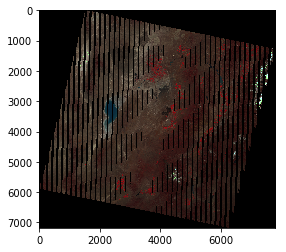

In [151]:
import rasterio
import numpy as np
import matplotlib.pyplot as plt

from rasterio.plot import show

fp = './landsat7_2012-05-13.tif'

# Open the file:
raster = rasterio.open(fp)

# Convert to numpy arrays
nir = raster.read(4)
red = raster.read(3)
green = raster.read(2)

# Stack bands
nrg = np.dstack((nir*0.0001, red*0.0001, green*0.0001))

plt.imshow(nrg)


https://gis.stackexchange.com/questions/221292/retrieve-pixel-value-with-geographic-coordinate-as-input-with-gdal